# 2022 年度 データマイニング データ解析レポート課題 

## 欠測値処理を導入したクラスター分析 BGA22078 中谷友哉

In [2]:
import glob, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
random.seed(0)

### 前処理(画像データの前景をカラーチャネルごとに画素値分布のヒストグラムデータに変換する)

花画像における前景部分の画素値分布をマスク画像を用いて抽出し，それらをカラーチャネルごとに17分割したヒストグラムに変換する．  
すなわち，一枚の画像データを17\*3=51の特徴量ベクトルに変換する．  
(data0-14: AnemoneHybrida, data15-29: AnemoneNikoensis, data30-44: AnemonePulsatilla)

In [3]:
num_feature_per_channel = 17
num_data_per_class = 15

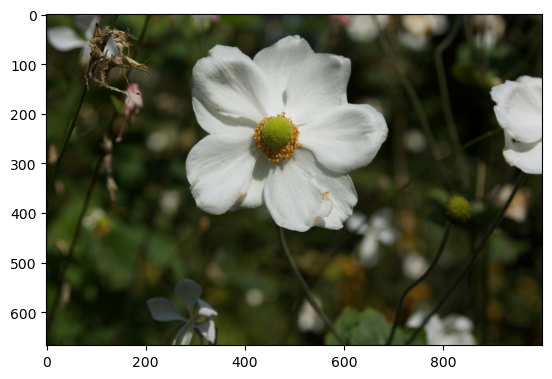

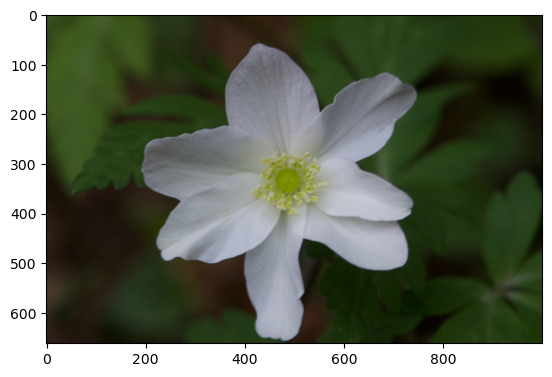

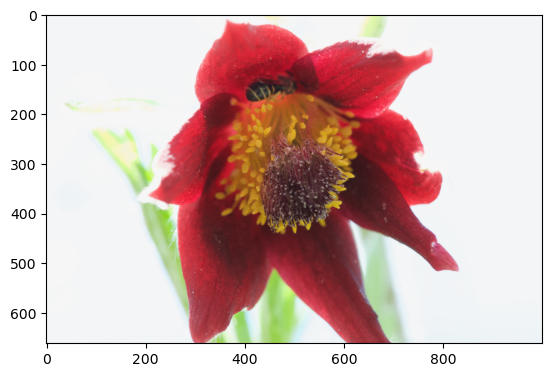

data_idx_arr: [2, 13, 16, 19, 22, 24, 25, 26, 30, 31, 32, 40]


In [4]:
pth_data = '/Users/nakatani/Desktop/22前期/データマイニング/report/data/img/xxx/*.png'
pth_mask = '/Users/nakatani/Desktop/22前期/データマイニング/report/data/mask/xxx/*.png'
labels = ['AnemoneHybrida', 'AnemoneNikoensis', 'AnemonePulsatilla']
all_data = []

for label in labels:
    imgs = sorted(glob.glob(pth_data.replace('xxx', label)))
    masks = sorted(glob.glob(pth_mask.replace('xxx', label)))
    data = []
    for path_img, path_mask in zip(imgs[:num_data_per_class], masks[:num_data_per_class]):
        img = cv2.imread(path_img)
        mask = cv2.imread(path_mask, 0)
        hist3c = []
        for i in range(3):
            img_1c = img[:, :, i]
            arr = img_1c[mask==255]
            hist1c, bins = np.histogram(arr, bins=np.linspace(0, 255, num_feature_per_channel+1))
            hist3c.extend(hist1c)
        all_data.append(hist3c)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
        
df = pd.DataFrame(all_data)
df['label'] = [i//num_data_per_class for i in range(num_data_per_class*3)]
data_idx_arr = random.sample(range(num_data_per_class*3), 12)
print(f'data_idx_arr: {sorted(data_idx_arr)}')
for data_idx in data_idx_arr:
    feature_idx = np.random.randint(num_feature_per_channel*3)
    df.iloc[data_idx, feature_idx] = np.nan
df.to_csv('../data/df_incomp.csv', index=False)

In [5]:
def k_means(arr2d, vec_centers):
    cls = []
    #クラスタ割り当て
    for arr in arr2d:
        # df_distにしてnanを含む行を削除
        df_dist = pd.DataFrame([arr, vec_centers[0], vec_centers[1], vec_centers[2]])
        df_dist = df_dist.dropna(how='any', axis=1)

        #　特徴ベクトルと3つのクラスタ中心の距離計算を行う
        for i in range(3):
            df_dist.iloc[i+1, :] -= df_dist.iloc[0, :]
        dist = [np.dot(vec_dist, vec_dist) for vec_dist in df_dist.iloc[1:, :].values]
        cls.append(np.argmin(dist))
    df['cls'] = cls
    vec_centers = []
    for i in range(3):
        cls_i = df[df['cls']==i]
        num_nan = cls_i.isnull().sum()[:num_feature_per_channel*3]
        num_comp = np.ones(num_feature_per_channel*3)*len(cls_i) - np.array(num_nan)
        mean = cls_i.sum()[:num_feature_per_channel*3] / num_comp
        vec_centers.append(mean)
    
    return vec_centers, cls

In [6]:
df = pd.read_csv('../data/df_incomp.csv')
arr2d = df.values[:, :-1]
n = num_feature_per_channel*3
vec_centers = [np.zeros(n)*6000, np.ones(n)*10000, np.ones(n)*15000]
cls = []
for i in range(100):
    print(np.array(cls))
    cls_prev = cls
    vec_centers, cls = k_means(arr2d, vec_centers)
    if cls == cls_prev:
        break

[]
[1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2]
[1 1 0 1 2 0 0 2 1 0 2 0 1 1 1 0 1 1 2 0 2 2 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[2 2 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 2 2 0 2 2 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[2 2 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 2 2 1 2 0 0 2 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


In [7]:
for i, label in enumerate(labels):
    print(f'{label}', cls[i*num_data_per_class:(i+1)*num_data_per_class])

AnemoneHybrida [2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0]
AnemoneNikoensis [0, 0, 2, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0]
AnemonePulsatilla [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 考察

今回は，色情報をヒストグラム表現した特徴量を用いて欠損値を含むデータのクラスタリングを行った．
形状情報を用いていないため，色情報が近いAnemoneHybridaとAnemoneNikoensisはお互いに区別できておらず，赤みが強いAnemonePulsatillaのみ綺麗にクラスタを形成する結果となった．